## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [15]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt --break-system-packages
# ! pip install nltk --break-system-packages
# ! pip install torchtext==0.6.0 --break-system-packages

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



#### Grading criteria

**100%**
- implementation of at least 3 model improvements over baseline
- threshold of 27 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**70%**
- implementation of at least 2 model improvements over baseline
- threshold of 25 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**30%**
- implementation of at least 1 model improvement over baseline
- threshold of 21 BLEU on test corpus
- experimental results and conclusions in human-readable format :)


------

#### **Note: Please do not use pretrained machine translation / BERT / LLM checkpoints. All such solutions will be graded at 30% pts.**


### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [2]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [3]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

import sentencepiece as spm
import pandas as pd

data = pd.read_csv(path_do_data, sep = "\t", header = None).sample(frac = .8)

data[1].to_csv("ru.txt", sep = '\t', header = False, index = False)
data[0].to_csv("eng.txt", sep = '\t', header = False, index = False)

spm.SentencePieceTrainer.train(input = 'ru.txt', model_prefix = 'ru', vocab_size = 3000, model_type = 'bpe')
spm.SentencePieceTrainer.train(input = 'eng.txt', model_prefix = 'eng', vocab_size = 2000, model_type = 'bpe')

engTokenizer = spm.SentencePieceProcessor()
ruTokenizer = spm.SentencePieceProcessor()
engTokenizer.Load('eng.model')
ruTokenizer.Load('ru.model')

def bpe_tokenizer_en(x):
  return engTokenizer.encode(x, out_type = str)

def bpe_tokenizer_ru(x):
  return ruTokenizer.encode(x, out_type = str)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ru.txt
  input_format: 
  model_prefix: ru
  model_type: BPE
  vocab_size: 3000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_

In [4]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

SRC_BPE = Field(tokenize=bpe_tokenizer_en,
                init_token = '<sos>',
                eos_token = '<eos>',
                lower = True)

TRG_BPE = Field(tokenize=bpe_tokenizer_ru,
                init_token = '<sos>',
                eos_token = '<eos>',
                lower = True)

dataset_bpe = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG_BPE), ('src', SRC_BPE)]
)

In [5]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
train_data_bpe, valid_data_bpe, test_data_bpe = dataset_bpe.split(split_ratio=[0.8, 0.15, 0.05])

In [6]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [7]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

SRC_BPE.build_vocab(train_data_bpe, min_freq = 3)
TRG_BPE.build_vocab(train_data_bpe, min_freq = 3)

In [8]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

print(f"Unique tokens in source (ru) bpe vocabulary: {len(SRC_BPE.vocab)}")
print(f"Unique tokens in target (en) bpe vocabulary: {len(TRG_BPE.vocab)}")

Unique tokens in source (ru) vocabulary: 9322
Unique tokens in target (en) vocabulary: 6714
Unique tokens in source (ru) bpe vocabulary: 8601
Unique tokens in target (en) bpe vocabulary: 464


Here are tokens from original (RU) corpus:

In [9]:
print(SRC.vocab.itos[::1000])

print(SRC_BPE.vocab.itos[::1000])

['<unk>', 'airport', 'экскурсию', 'курение', 'хвар', 'футон', 'palais', 'уединенный', 'дар', 'смотровая']
['<unk>', 'традиционный', 'no', 'предоставит', '▁oper', 'пейзажный', 'брайтона', 'акротири', 'питерборо']


And from target (EN) corpus:

In [10]:
print(TRG.vocab.itos[::1000])

print(TRG_BPE.vocab.itos[::1000])

['<unk>', 'breakfasts', 'designated', 'brest', 'michigan', 'seater', 'mactan']
['<unk>']


And here is example from train dataset:

In [11]:
print(vars(train_data.examples[9]))
print(vars(train_data_bpe.examples[9]))

{'trg': ['a', 'daily', 'breakfast', 'is', 'included', '.'], 'src': ['в', 'стоимость', 'входит', 'ежедневный', 'завтрак', '.']}
{'trg': ['▁a', '▁d', 'a', 'il', 'y', '▁', 'b', 're', 'ak', 'f', 'ast', '▁', 'is', '▁', 'in', 'c', 'l', 'ud', 'ed', '.'], 'src': ['▁', 'в', '▁', 'стоимость', '▁', 'входит', '▁', 'ежедневный', '▁', 'завтрак', '.']}


Let's check the length distributions:

Length distribution in Train data


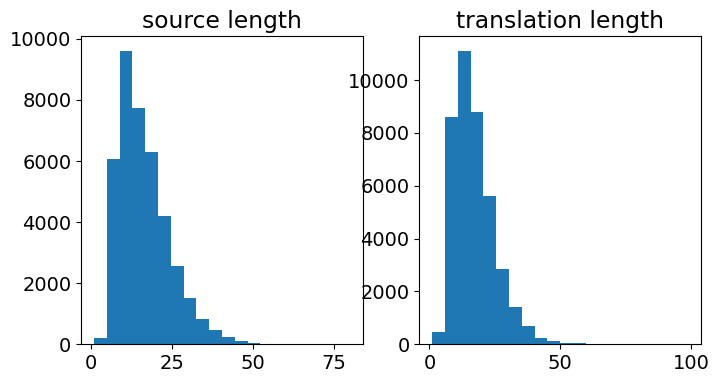

In [12]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


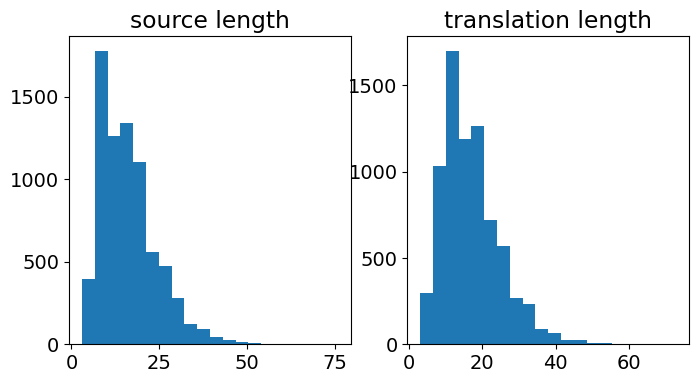

In [13]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week02 practice__

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
device

device(type='cuda')

In [16]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [17]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 47x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 56x128 (GPU 0)]
torch.Size([56, 128]) torch.Size([47, 128])


In [18]:
import my_network
import imp
imp.reload(my_network)
import utils

Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

/tmp/ipykernel_377393/2719505689.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [19]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
model, optimizer, criterion = utils.initModel(model, TRG.vocab.stoi['<pad>'])

The model has 17,389,875 trainable parameters


In [19]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

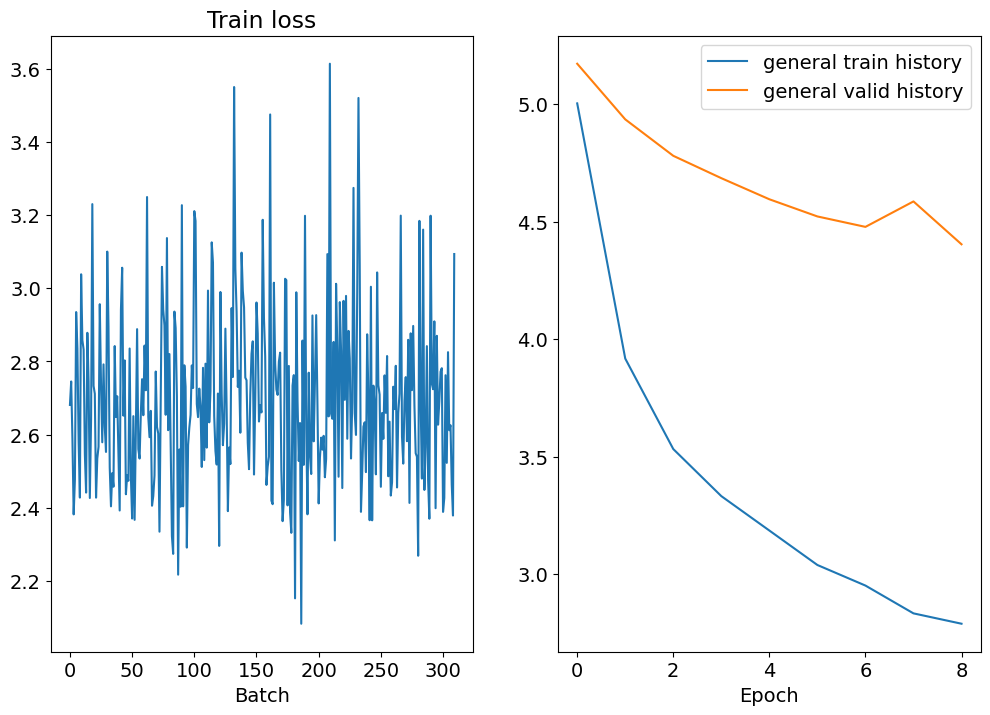

In [24]:
with open("baseline.log", "a") as logFile:
    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut1-model.pt')

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', file=logFile, flush=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}', file=logFile, flush=True)
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}', file=logFile, flush=True)

__Let's take a look at our network quality__:

In [26]:
import utils
import imp
imp.reload(utils)

print(f"BLEU = {utils.validate(test_iterator, model, TRG, tokenize, utils.generate_translation)}")

Original: guests are offered a hairdryer and slippers .
Generated: for your comfort , you will find slippers and a hairdryer .

Original: breakfast is served in the restaurant .
Generated: the restaurant serves a cuisine .

Original: the bathroom has a shower .
Generated: the bathroom comes with a shower and shower .

Original: free wifi access is available .
Generated: free wifi access is available .

Original: there are shops at the property .
Generated: there is also a restaurants in the property .



4it [00:00, 12.17it/s]

59it [00:07,  7.62it/s]


BLEU = 20.4919230447912


# BPE

In [57]:
import my_network
import imp
imp.reload(my_network)
import utils

Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

INPUT_DIM = len(SRC_BPE.vocab)
OUTPUT_DIM = len(TRG_BPE.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
model, optimizer, criterion = utils.initModel(model, TRG_BPE.vocab.stoi['<pad>'])

The model has 9,919,702 trainable parameters


In [58]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data_bpe, valid_data_bpe, test_data_bpe),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 164x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 91x128 (GPU 0)]
torch.Size([91, 128]) torch.Size([164, 128])


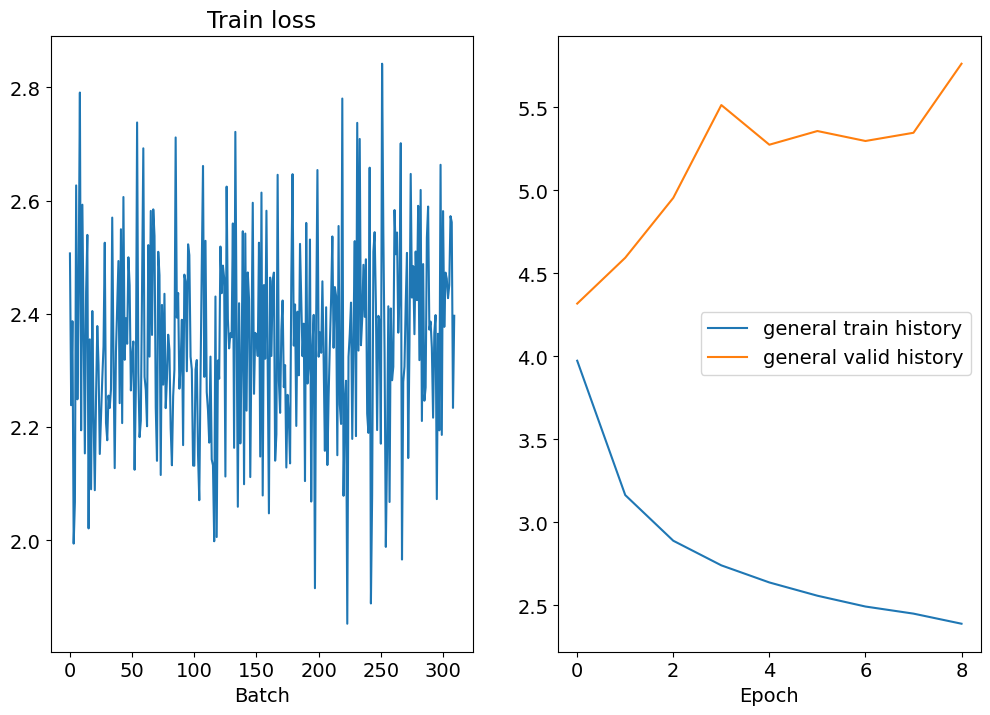

In [59]:
with open("bpe.log", "a") as logFile:
    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut2-model.pt')

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', file=logFile, flush=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}', file=logFile, flush=True)
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}', file=logFile, flush=True)

In [60]:
print(f"BLEU = {utils.validate(test_iterator, model, TRG_BPE, engTokenizer, utils.generate_translation_bpe)}")

Original: guest rooms at the ft.
Generated: the rooms at the hotel 

Original: a tv is provided.
Generated: the apartment is fitted with a kitchen.

Original: you will find a 24-hour front desk at the property.
Generated: the  roperty offers free parking.

Original: a pillow menu is available.
Generated: a breakfast is served in the morning.

Original: for your comfort, you will find slippers and a hairdryer.
Generated: there is a full kitchen with a microwave.



59it [00:05, 10.71it/s]


BLEU = 17.385502321373536


# BPE + Attention

In [25]:
import my_network
import imp
imp.reload(my_network)
import utils

Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

INPUT_DIM = len(SRC_BPE.vocab)
OUTPUT_DIM = len(TRG_BPE.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, False, True)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, False, True)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
model, optimizer, criterion = utils.initModel(model, TRG_BPE.vocab.stoi['<pad>'])

The model has 12,929,999 trainable parameters


In [26]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data_bpe, valid_data_bpe, test_data_bpe),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 184x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 94x128 (GPU 0)]
torch.Size([94, 128]) torch.Size([184, 128])


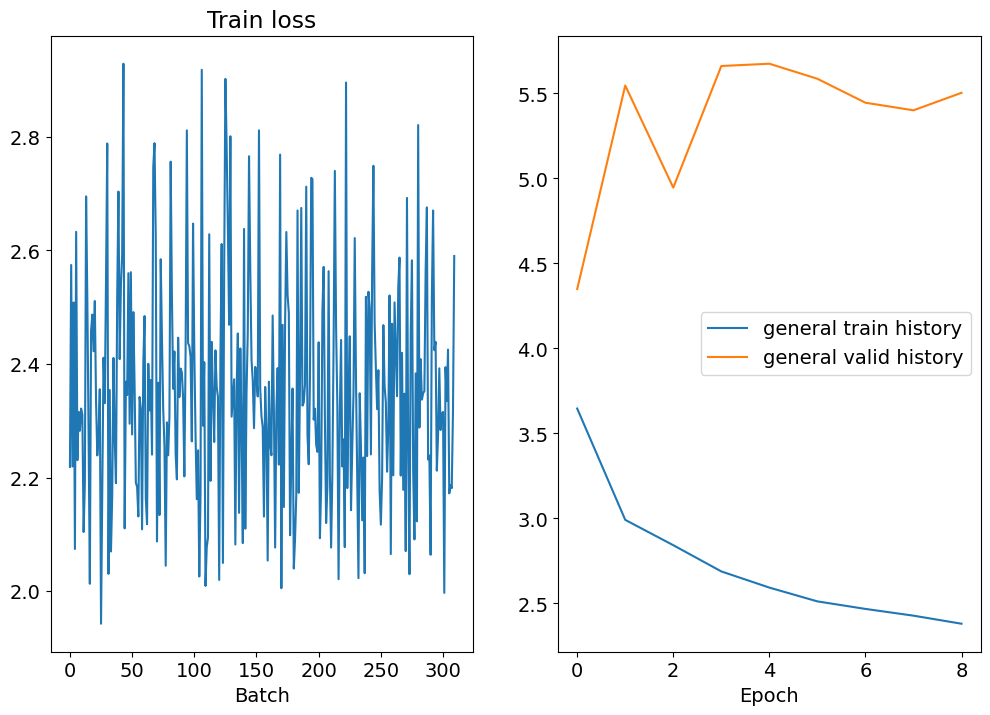

In [27]:
with open("bpe_att.log", "a") as logFile:
    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut3-model.pt')

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', file=logFile, flush=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}', file=logFile, flush=True)
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}', file=logFile, flush=True)

In [28]:
print(f"BLEU = {utils.validate(test_iterator, model, TRG_BPE, engTokenizer, utils.generate_translation_bpe)}")

Original: guests can enjoy the on-site bar.
Generated: there is a shared lounge.

Original: all rooms include a shared bathroom.
Generated: the bathroom is fitted with a shower.

Original: you will find a 24-hour front desk at the property.
Generated: there is a 24-hour front desk at the property.

Original: all the rooms have balconies.
Generated: all rooms are equipped with a shared bathroom.

Original: the living room features a fireplace.
Generated: a fully equipped kitchen with a microwave and a refrigerator.



59it [00:04, 11.82it/s]


BLEU = 23.150664581079944


# BPE + Attention + Positional encoding

In [16]:
import my_network
import imp
imp.reload(my_network)
import utils

Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

INPUT_DIM = len(SRC_BPE.vocab)
OUTPUT_DIM = len(TRG_BPE.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, True, True)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, True, True)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
model, optimizer, criterion = utils.initModel(model, TRG_BPE.vocab.stoi['<pad>'])

/tmp/ipykernel_389531/2118686901.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


The model has 12,932,816 trainable parameters


In [17]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data_bpe, valid_data_bpe, test_data_bpe),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 126x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 83x128 (GPU 0)]
torch.Size([83, 128]) torch.Size([126, 128])


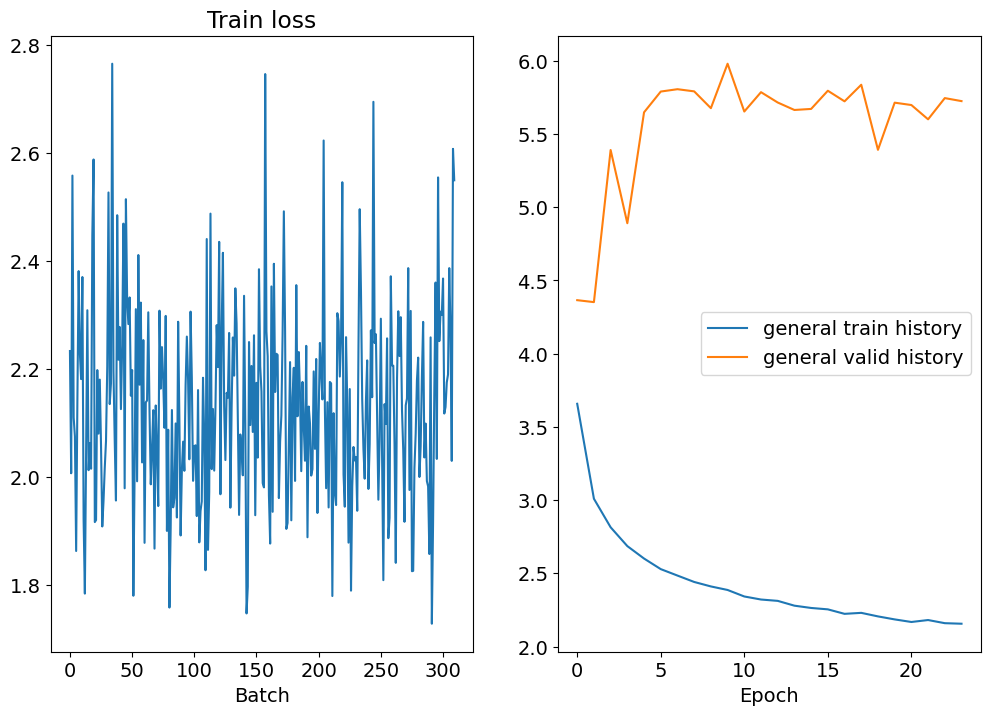

59it [00:06,  9.23it/s]


27.570270242534622


In [22]:
epoch = 0
with open("bpe_att_posEnc.log", "a") as logFile:
    score = 0
    while score < 27:
        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut4-model.pt')

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', file=logFile, flush=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}', file=logFile, flush=True)
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}', file=logFile, flush=True)
        score = utils.validate(test_iterator, model, TRG_BPE, engTokenizer, utils.generate_translation_bpe, True)
        print(score)
        epoch += 1

In [23]:
print(f"BLEU = {utils.validate(test_iterator, model, TRG_BPE, engTokenizer, utils.generate_translation_bpe)}")

Original: 24-hour room service is provided.
Generated: room service is available for free.

Original: you will find a 24-hour front desk at the property.
Generated: there is a 24-hour front desk at the property.

Original: the reception desk is open 24 hours a day.
Generated: there is a 24-hour front desk at the property.

Original: all units feature a tv.
Generated: all units include a tv.

Original: this hotel does not have a restaurant.
Generated: there is also a restaurant with a sar.



19it [00:01, 17.31it/s]

59it [00:04, 12.03it/s]


BLEU = 27.599465061189143


# Results

Some upgrades were used in this lab
- BPE tokenization
- attention
- positional encoding
- Also I change LSTM to GRU for better results and googling...

After each of it we get upgades of quality of results in table below

| model         | BLEU Score      |
|:------------- |:---------------:|
| baseline      | 12.81 |
| BPE on baseline          | 17.39           |
| baseline GRU | 20.37 |
| BPE with attention (GRU) | 23.15 |
| BPE with attention and positional encoding (GRU) (10 epochs)| 26.42 |
| BPE with attention and positional encoding (GRU) (25 epochs)| 27.59 |

I think it is good result and further learning can made it better